# IRTモデルの識別性

項目反応理論（IRT）モデルでは、能力パラメータ$\theta$と項目パラメータ（$a, b$など）を同時に推定する。しかし、何らかの制約を課さなければパラメータが一意に定まらない **識別性（identifiability）** の問題がある。

## 識別性の問題とは

**識別性（identifiability）** とは、観測データからモデルのパラメータを一意に決定できるかどうかという性質である。

IRTモデルでは、2パラメータロジスティックモデル（2PLM）を例にとると

$$
P(u_{ij} = 1 \mid \theta_i, a_j, b_j) = \frac{1}{1 + \exp(-a_j(\theta_i - b_j))}
$$

というモデルを考える。このとき、能力パラメータ$\theta$と項目パラメータ$(a, b)$の間には本質的な不定性が存在する。

### 位置の不定性（Location Indeterminacy）

能力パラメータ$\theta$と困難度パラメータ$b$に同じ定数$c$を加えても、モデルの予測確率は変わらない。

$$
a_j(\theta_i - b_j) = a_j((\theta_i + c) - (b_j + c))
$$

つまり、$(\theta, b)$と$(\theta + c, b + c)$は観測データに対して同じ尤度を与える。これを **位置の不定性** という。

直感的には「全員の能力を10点ずつ上げて、全問題の難易度も10点ずつ上げても、正答確率は変わらない」ということである。

### 尺度の不定性（Scale Indeterminacy）

能力パラメータ$\theta$と困難度パラメータ$b$を同じ正の定数$k > 0$で割り、識別力パラメータ$a$を$k$倍しても、モデルの予測確率は変わらない。

$$
a_j(\theta_i - b_j) = (k \cdot a_j)\left(\frac{\theta_i}{k} - \frac{b_j}{k}\right)
$$

つまり、$(a, \theta, b)$と$(ka, \theta/k, b/k)$は観測データに対して同じ尤度を与える。これを **尺度の不定性** という。

直感的には「能力と難易度の単位を変えても（例：点数からパーセントに変換）、識別力を適切に調整すれば正答確率は変わらない」ということである。

## 識別性の確保

識別性の問題を解決するためには、パラメータに制約を課す必要がある。主に2つのアプローチがある。

1. **能力パラメータへの制約**：能力$\theta$の分布を固定する
2. **項目パラメータへの制約**：特定の項目のパラメータを固定する

### 能力パラメータへの制約

最も一般的な方法は、能力パラメータ$\theta$が標準正規分布に従うと仮定することである。

$$
\theta_i \sim \mathcal{N}(0, 1)
$$

この制約により：

- **位置の不定性の解消**：$\mathrm{E}[\theta] = 0$と固定することで、$\theta$と$b$に任意の定数を加える自由度がなくなる
- **尺度の不定性の解消**：$\mathrm{Var}[\theta] = 1$と固定することで、$\theta$と$b$を任意の定数で割る自由度がなくなる

この制約は周辺最尤推定法（MML）やベイズ推定で自然に導入される。

### 項目パラメータへの制約

別のアプローチとして、特定の項目パラメータを固定する方法がある。

例えば：

- **1つの項目の困難度を固定**：$b_1 = 0$（位置の不定性を解消）
- **1つの項目の識別力を固定**：$a_1 = 1$（尺度の不定性を解消）

または、複数の項目パラメータの平均や分散を固定する方法もある：

- $\frac{1}{J}\sum_{j=1}^{J} b_j = 0$（困難度の平均を0に固定）
- $\frac{1}{J}\sum_{j=1}^{J} a_j = 1$（識別力の平均を1に固定）

この方法は同時最尤推定法（JML）でよく用いられる。

## シミュレーション：識別性の問題の確認

識別性の問題を具体的に確認するため、同じデータに対して異なるパラメータが同じ尤度を与えることを示す。

In [1]:
import numpy as np

def icc_2pl(theta, a, b):
    """2PLモデルのICC（項目特性曲線）"""
    return 1 / (1 + np.exp(-a * (theta - b)))

def log_likelihood(responses, theta, a, b):
    """対数尤度の計算"""
    prob = icc_2pl(theta[:, None], a, b)
    ll = np.sum(responses * np.log(prob + 1e-10) + (1 - responses) * np.log(1 - prob + 1e-10))
    return ll

# 真のパラメータ
np.random.seed(42)
n_persons, n_items = 100, 5
theta_true = np.random.normal(0, 1, n_persons)
a_true = np.array([1.0, 1.2, 0.8, 1.5, 1.1])
b_true = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])

# データ生成
prob = icc_2pl(theta_true[:, None], a_true, b_true)
responses = np.random.binomial(1, prob)

# 真のパラメータでの対数尤度
ll_true = log_likelihood(responses, theta_true, a_true, b_true)
print(f"真のパラメータでの対数尤度: {ll_true:.4f}")

真のパラメータでの対数尤度: -278.3950


### 位置の不定性の確認

In [2]:
# 位置の不定性：θとbに同じ定数cを加える
c = 5.0  # 任意の定数
theta_shifted = theta_true + c
b_shifted = b_true + c

ll_shifted = log_likelihood(responses, theta_shifted, a_true, b_shifted)
print(f"位置をシフトしたパラメータでの対数尤度: {ll_shifted:.4f}")
print(f"差: {abs(ll_true - ll_shifted):.10f}")

位置をシフトしたパラメータでの対数尤度: -278.3950
差: 0.0000000000


### 尺度の不定性の確認

In [4]:
# 尺度の不定性：θとbをkで割り、aをk倍する
k = 2.0  # 任意の正の定数
theta_scaled = theta_true / k
b_scaled = b_true / k
a_scaled = a_true * k

ll_scaled = log_likelihood(responses, theta_scaled, a_scaled, b_scaled)
print(f"尺度を変換したパラメータでの対数尤度: {ll_scaled:.4f}")
print(f"差: {abs(ll_true - ll_scaled):.10f}")

尺度を変換したパラメータでの対数尤度: -278.3950
差: 0.0000000000


上記のように、異なるパラメータの組み合わせが全く同じ対数尤度を与えることが確認できた。これが識別性の問題である。

## 視覚的な確認

異なるパラメータ化でも、正答確率（ICC）は同じになることを確認する。

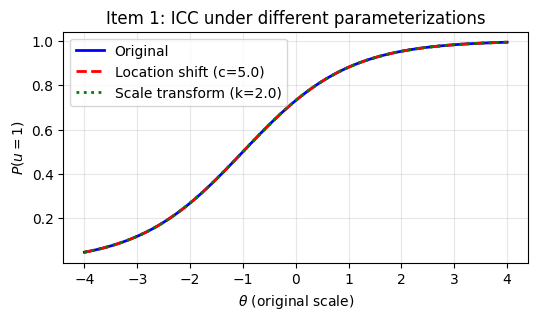

In [5]:
import matplotlib.pyplot as plt

# 項目1のICCを比較
theta_range = np.linspace(-4, 4, 100)
j = 0  # 項目1

# 真のパラメータでのICC
icc_true = icc_2pl(theta_range, a_true[j], b_true[j])

# 位置シフトしたパラメータでのICC（θも調整が必要）
icc_shifted = icc_2pl(theta_range + c, a_true[j], b_shifted[j])

# 尺度変換したパラメータでのICC（θも調整が必要）
icc_scaled = icc_2pl(theta_range / k, a_scaled[j], b_scaled[j])

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(theta_range, icc_true, 'b-', linewidth=2, label='Original')
ax.plot(theta_range, icc_shifted, 'r--', linewidth=2, label=f'Location shift (c={c})')
ax.plot(theta_range, icc_scaled, 'g:', linewidth=2, label=f'Scale transform (k={k})')
ax.set(xlabel=r'$\theta$ (original scale)', ylabel=r'$P(u=1)$', title='Item 1: ICC under different parameterizations')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

3つの曲線が完全に重なっており、異なるパラメータ化が同じ正答確率を生成することが確認できる。

## ベイズ推定における識別性

ベイズ推定では、事前分布を通じて識別性を確保することが自然にできる。

### 標準的な事前分布の設定

$$
\begin{aligned}
\theta_i &\sim \mathcal{N}(0, 1) \\
a_j &\sim \text{LogNormal}(0, \sigma_a^2) \quad \text{or} \quad a_j \sim \text{HalfNormal}(\sigma_a) \\
b_j &\sim \mathcal{N}(0, \sigma_b^2)
\end{aligned}
$$

- $\theta \sim \mathcal{N}(0, 1)$：位置と尺度の両方を固定
- $a_j > 0$の制約：識別力は正であるべき（負だとICCの傾きが反転する）
- $b_j$には緩い正規分布：困難度の範囲を緩やかに制限

## 1PLモデル（Raschモデル）の識別性

1PLモデルでは識別力$a$がすべての項目で共通（通常$a=1$と固定）であるため、尺度の不定性は最初から存在しない。

$$
P(u_{ij} = 1 \mid \theta_i, b_j) = \frac{1}{1 + \exp(-(\theta_i - b_j))}
$$

この場合、位置の不定性のみを解消すればよく、以下のいずれかの制約を課す：

- $\sum_{i=1}^{I} \theta_i = 0$（能力の総和を0に固定）
- $\sum_{j=1}^{J} b_j = 0$（困難度の総和を0に固定）
- $\theta \sim \mathcal{N}(0, \sigma^2)$（能力の平均を0に固定）

## まとめ

| 不定性の種類 | 変換 | 解消方法 |
|:---|:---|:---|
| 位置の不定性 | $(\theta, b) \to (\theta + c, b + c)$ | $\mathrm{E}[\theta] = 0$ または $\sum b_j = 0$ |
| 尺度の不定性 | $(\theta, a, b) \to (\theta/k, ka, b/k)$ | $\mathrm{Var}[\theta] = 1$ または $a_1 = 1$ |

IRTモデルの推定では、これらの制約を意識することが重要である。特に：

1. 使用するソフトウェアがどの制約を採用しているか確認する
2. 異なる研究間でパラメータを比較する際は尺度を揃える
3. ベイズ推定では事前分布を通じて自然に識別性を確保できる

## 参考文献

<!-- - Baker, F. B., & Kim, S. H. (2004). *Item Response Theory: Parameter Estimation Techniques*. CRC Press.
- de Ayala, R. J. (2009). *The Theory and Practice of Item Response Theory*. Guilford Press.
- San Martín, E. (2015). Identification of item response theory models. In *Handbook of Item Response Theory* (pp. 127-150). Chapman and Hall/CRC. -->